Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [26]:
# download sentiment lexicon
#!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
#!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

In [3]:
import math
import os
import sys
from subprocess import call
import nltk
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print(len(reviews))

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
c_c = 0
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      c_c += 1

print("CC")        
print(c_c)
print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  

2000
0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
CC
1512359
#types 47743
Most common toke

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [5]:
# YOUR CODE HERE
def sent_lex_to_dict():
    
    sent_lex_dict = {}
    
    with open("sent_lexicon", mode="r", encoding="utf-8") as f:
        sent_lex = f.readlines()
    
    for sent_obs in sent_lex:
        
        sent_list = sent_obs.split(" ")
        word = sent_list[2].split("=")[1]
        
        word_info = [x.split("=")[1] for i,x in enumerate(sent_list) if i!=2]
        word_info[-1] = word_info[-1][:-1] 
        
        sent_lex_dict[word] = word_info
    
    return sent_lex_dict

def create_bag_of_words(review):
    bag_of_words = Counter()
    
    for sentence in review["content"]:
        for token, pos_tag in sentence:
            bag_of_words[token.lower()] += 1
        
    return bag_of_words
    
def classify_s_binary(review, sent_lex, weights):
    
    bow = create_bag_of_words(review)
    
    count_positive = 0
    count_negative = 0
    
    for word in bow:
        if word in sent_lex:
            word_info = sent_lex[word]
        else:
            continue
            
        sentiment = word_info[-1]
        
        s_strength = word_info[0]
        
        word_count = bow[word]
        
        if s_strength == 'strongsubj':
            word_count *= weights[0]
        else:
            word_count *= weights[1]
        
        if sentiment == 'positive':
            count_positive += word_count
        elif sentiment == 'negative':
            count_negative += word_count
        else:
            continue
        #elif sentiment == 'neutral':
        #    continue
        #else:
        #    raise Exception("Sentiment is neither positive, negative or neutral. Its " + sentiment + ".")
     
    final_count = count_positive - count_negative
    
    # classify does not justify a own function?
    if final_count > 8:
        return 'POS'
    else:
        return 'NEG'
    
    
def compute_accuracy(cm):
    return float(cm[0] + cm[3]) / sum(cm)


def evaluate_symbolic_approach(strong_w, weak_w):
    
    sent_lex_dict = sent_lex_to_dict()

    # list with the classification results. True => positive; False: Negative
    prediction = []
    ground_truths = []
    token_results = []

    # TP, FP, FN, TN
    confusion_matrix = [0, 0, 0, 0]

    for review in reviews:
        gt_sentiment = review['sentiment']
        current_prediction = classify_s_binary(review, sent_lex_dict, [strong_w, weak_w])

        prediction.append(current_prediction)
        ground_truths.append(gt_sentiment)

        if gt_sentiment == current_prediction:
            token_results.append('+')
            if current_prediction == 'POS':
                confusion_matrix[0] += 1
            else:
                confusion_matrix[3] += 1
        else:
            token_results.append('-')
            if current_prediction == 'POS':
                confusion_matrix[1] += 1
            else:
                confusion_matrix[2] += 1

    accuracy = compute_accuracy(confusion_matrix)
    
    return accuracy, token_results


In [6]:
token_accuracy, token_results = evaluate_symbolic_approach(1, 1)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [7]:
magnitude_accuracy, magnitude_results = evaluate_symbolic_approach(1, 0.5)

In [8]:
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.69


#### Optional: make a barplot of the two results.

<function matplotlib.pyplot.show(*args, **kw)>

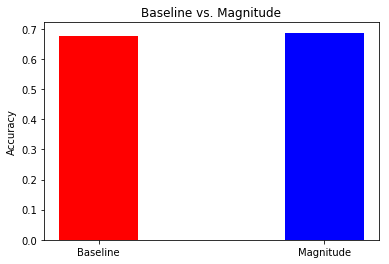

In [9]:
width = 0.35
height = 1.0

fig, ax = plt.subplots()
bar_baseline = ax.bar(0, token_accuracy, width, color='Red', label='Token')
bar_magnitude = ax.bar(1, magnitude_accuracy, width, color='Blue', label='Magnitude')

plt.ylabel('Accuracy')
plt.title('Baseline vs. Magnitude')
plt.xticks((0, 1), ('Baseline', 'Magnitude'))
# plt.legend((bar_baseline[0], bar_magnitude[0]), ('Men', 'Women'))
plt.show

Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [10]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0

  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]=="-": 
      plus += 1
    elif results_2[i]=="-": 
      minus += 1
    
  n = 2*np.ceil(float(ties)/2) + plus + minus
  k = np.ceil(float(ties/2)) + np.min(np.asarray([plus, minus]))
          
  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
    summation += Decimal(comb(n, i, True)) #* Decimal(pow(0.5, i)) * Decimal(pow((1-0.5), (n-i)))

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))
  
  # print("the difference is", "not significant" if summation >= 0.05 else "significant")
  
  return summation

# baseline
token_accuracy, token_results = evaluate_symbolic_approach(1, 1)

# magnitude
magnitude_accuracy, magnitude_results = evaluate_symbolic_approach(1, 0.5)

p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

p_value = 0.6874061571902917775322357382


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [11]:
# YOUR CODE HERE

def train_bayes(V, K_laplace, negatives, positives):
    
    classes = ["POS", "NEG"]
    
    neg_docs = negatives #:900
    pos_docs = positives #1000:1900
    
    pos_neg_docs = [pos_docs, neg_docs]
    
    n_doc = len(pos_docs) + len(neg_docs)
    
    log_prior =  []
    log_likelihood = {}

    for i, c in enumerate(classes): 
        
        # prior P(c) we ask what: percentage of the documents in our training set are in each class c.
        n_c = len(pos_neg_docs[i])
        log_prior.append(np.log(float(n_c) / n_doc))
        
        big_doc = Counter()
        for review in pos_neg_docs[i]:
            for sentence in review["content"]:
                for token, pos_tag in sentence:
                    big_doc[token.lower()] += 1
        
        v_sum_c = 0
        for word in V:
            v_sum_c += (big_doc[word] + K_laplace)
            # Added by Arvid, this is the smoothing factor in pseudo-code at page 7 for the denominator of the log_p_w_c
            
        for word in V:
            w_count = big_doc[word]
            
            # the fraction of times the word w_i appears among all words in all documents of class c.
            # with laplace smoothing
            if((K_laplace == 0) and (w_count == 0)):
                log_p_w_c = 0
            else:
                log_p_w_c = np.log(float(w_count + K_laplace) / (v_sum_c))
            
            # log likelyhood: dictionary with word as key and list with log p pos and log p neg
            if word in log_likelihood:
                log_likelihood[word].append(log_p_w_c)
            else:
                log_likelihood[word] = [log_p_w_c]
    
    return log_prior, log_likelihood

def predict_with_bayes(test_docs, log_prior, log_likelihood, V):
    classes = ["POS", "NEG"]
    
    predictions = []
        
    for i, doc in enumerate(test_docs):
        c_sum = np.asarray([0, 0], np.float64)
        for j, c in enumerate(classes):
            c_sum[j] += log_prior[j]
            
            likelihoods = []
            for sentence in doc['content']:
                for word_pair in sentence:
                    word = word_pair[0]
                    if word in V:
                        c_sum[j] += log_likelihood[word][j]

        predictions.append(classes[np.argmax(c_sum)])
    
    return predictions
    

def test_bayes(log_prior, log_likelihood, V, negatives, positives):
    neg_docs = negatives #900:1000
    pos_docs = positives    #1900:
   
    test_docs = pos_docs + neg_docs
    
    ground_truth = []
    for doc in test_docs:
        ground_truth.append(doc['sentiment'])
        
    predictions = predict_with_bayes(test_docs, log_prior, log_likelihood, V)
    
    # TP, FP, FN, TN
    confusion_matrix = [0, 0, 0, 0]
    bayes_results = []

    for i, item in enumerate(predictions):
        gt_sentiment = ground_truth[i]
        current_prediction = predictions[i]

        if gt_sentiment == current_prediction:
            bayes_results.append('+')
            if current_prediction == 'POS':
                confusion_matrix[0] += 1
            else:
                confusion_matrix[3] += 1
        else:
            bayes_results.append('-')
            if current_prediction == 'POS':
                confusion_matrix[1] += 1
            else:
                confusion_matrix[2] += 1

    accuracy = compute_accuracy(confusion_matrix)
    return accuracy, bayes_results

# setup         
# the vocabulary V: consists of the union of all the word types in all classes
V = set()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      V.add(token.lower())
    
# These have been moved outside the functions to manipulate them easier 
train_neg = reviews[:900]
train_pos = reviews[1000:1900]
test_neg = reviews[900:1000]
test_pos = reviews[1900:]
log_prior, log_likelihood = train_bayes(V, 1, train_neg, train_pos)        
accuracy, bayes_results = test_bayes(log_prior, log_likelihood, V, test_neg, test_pos)

print("The final accuracy: " + str(np.round(accuracy, 4)))

The final accuracy: 0.865


#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [12]:
# Answer:
# In the train_bayes function we change the data-split to 
neg_docs = reviews[:89] 
pos_docs = reviews[1000:1900]
log_prior, log_likelihood = train_bayes(V, 1, neg_docs, pos_docs)  

# and in the test_bayes function we change to:
neg_docs = reviews[900:910] #900:1000
pos_docs = reviews[1900:]    #1900:
accuracy, bayes_results_smoothing = test_bayes(log_prior, log_likelihood, V, neg_docs, pos_docs)
print("The accuracy we get with the skewed data: " + str(np.round(accuracy, 4)))

# This yields a final accuracy of 0.9090.
# Because the training and testing data is biased towards 
# positive instances, the model can achieve a very high accuracy 
# by simply stating that all reviews are positive. There is no need 
# to classify the negatives correctly as they constitute only 10%
# of the data. For this reason, accuracy is a bad metric for unbalanced datasets

The accuracy we get with the skewed data: 0.9091


## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [13]:
train_neg = reviews[:900]
train_pos = reviews[1000:1900]
test_neg = reviews[900:1000]
test_pos = reviews[1900:]
log_prior, log_likelihood = train_bayes(V, 1, train_neg, train_pos)        
accuracy, bayes_results_smoothing = test_bayes(log_prior, log_likelihood, V, test_neg, test_pos)

print("The accuracy with smoothing (k=1): " + str(np.round(accuracy, 4)))

log_prior, log_likelihood = train_bayes(V, 0, train_neg, train_pos)        
accuracy, bayes_results_baseline = test_bayes(log_prior, log_likelihood, V, test_neg, test_pos)

print("The accuracy without smoothing: " + str(np.round(accuracy, 4)))

# Without using smoothing, the final
# accuracy is 0.51, With a K = 1, accuracy 
# increases to 0.865


# ANSWER WHAT DID WE DO TO CIRCUMVENT MATH ERROR

The accuracy with smoothing (k=1): 0.865
The accuracy without smoothing: 0.515


#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [14]:
# YOUR CODE HERE
train_neg = reviews[:900]
train_pos = reviews[1000:1900]
test_neg = reviews[900:1000]
test_pos = reviews[1900:]

#Results without smoothing
log_prior, log_likelihood = train_bayes(V, 0, train_neg, train_pos)        
accuracy, bayes_results_baseline = test_bayes(log_prior, log_likelihood, V, test_neg, test_pos)

#Results with smoothing
log_prior, log_likelihood = train_bayes(V, 1, train_neg, train_pos)        
accuracy, bayes_results_smoothing = test_bayes(log_prior, log_likelihood, V, test_neg, test_pos)

p_value = sign_test(bayes_results_baseline, bayes_results_smoothing)
print("The p-value: ", p_value)
#Answer: The p_value is very low, approx 8.32E-7, hence
#it is extremely unlikely that the classifier using smoothing 
#and the classifier without smoothing perform equally 

The p-value:  8.327913048391422592359667150E-7


## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [21]:
# YOUR CODE HERE
def N_fold_crossVal(N, reviews, V, test_for_V, classifier = 'naiveBayes'):
    accuracies = []
    class_results = []
    
    for i in range(N):
        chunk_i = range(i, 2000, N)
        chunk_remaining = list(set(range(0, 2000)) - set(chunk_i))
        train_neg = [i for i in chunk_remaining if i < 1000]
        train_pos = [i for i in chunk_remaining if i >= 1000]
        test_neg = [i for i in chunk_i if i < 1000]
        test_pos = [i for i in chunk_i if i >= 1000]
        #Train classifier on current Round-robin split 
        # we need to use indeces as indexes in reviews!.......
        
        # Only printing the held-out training set
        if test_for_V:
            if(i == (N - 1)):
                training_split_idxs = train_neg + train_pos
                train_reviews = [reviews[i] for i in training_split_idxs]
                V_count = set()
                for review in train_reviews:
                  for sentence in review["content"]:
                    for token, pos_tag in sentence:
                      V_count.add(token.lower())
                print("Amount of features in held-out training set: ", len(V_count))
        else:
        
            if classifier == 'naiveBayes':   
                log_prior, log_likelihood = train_bayes(V, 1, [reviews[i] for i in train_neg], 
                                                [reviews[i] for i in train_pos])        
                accuracy, bayes_results_smoothing = test_bayes(log_prior, log_likelihood, 
                                                V, [reviews[i] for i in test_neg], 
                                                [reviews[i] for i in test_pos])
                accuracies.append(accuracy)
                class_results += bayes_results_smoothing
            elif classifier == "SVM":
                X, y = reviews
                train_data = X[train_pos+train_neg]
                test_data = X[test_pos+test_neg]

                train_labels = y[train_pos+train_neg]
                test_labels = y[test_pos+test_neg]

                SVM = train_SVM(train_data, train_labels)
                accuracy, svm_results = test_SVM(SVM, test_data, test_labels)

                accuracies.append(accuracy)
                class_results += svm_results
    
        
    return accuracies, class_results

accuracies, bayes_results_smoothing = N_fold_crossVal(10, reviews, V, False)
print("All accuracies:" ,accuracies)
print("Mean accuracies:" ,np.mean(np.asarray(accuracies)))

All accuracies: [0.79, 0.825, 0.825, 0.845, 0.775, 0.835, 0.85, 0.795, 0.855, 0.835]
Mean accuracies: 0.8230000000000001


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [16]:
# See code above for function
print("Average accuracy = ", np.mean(accuracies))
print("Variance of accuracies = ", np.var(accuracies))
print("Standard Deviation:" ,np.std(np.asarray(accuracies)))

Average accuracy =  0.8230000000000001
Variance of accuracies =  0.0006709999999999986
Standard Deviation: 0.02590366769397721


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [17]:
def create_stem_reviews(reviews):
    
#    {"cv": integer, "sentiment": str, "content": list} 
    stemmer = PorterStemmer()
    
    V_stemmed = set()
    stemmed_reviews = []
    for review in reviews:
        
        stemmed_review = {}
        cv = review['cv']
        sentiment = review['sentiment']
        
        stemmed_review['cv'] = cv
        stemmed_review['sentiment'] = sentiment
        stemmed_content = []
       
        for sentence in review["content"]:
            stemmed_sentence = []
            for token, pos_tag in sentence:
                stemmed_word = stemmer.stem(token)
                stemmed_sentence.append([stemmed_word, pos_tag])
                V_stemmed.add(stemmed_word)
            stemmed_content.append(stemmed_sentence)
        
        stemmed_review["content"] = stemmed_content
        stemmed_reviews.append(stemmed_review)
        
    return V_stemmed, stemmed_reviews

V_stemmed, stemmed_reviews = create_stem_reviews(reviews)
accuracies_baseline, bayes_results_smoothing_baseline = N_fold_crossVal(10, reviews, V, False)
accuracies_stem, bayes_results_smoothing_stem = N_fold_crossVal(10, stemmed_reviews, V_stemmed, False)
    
print("BASELINE")
print(accuracies_baseline)
print("Average accuracy = ", np.mean(np.asarray(accuracies_baseline)))

print("STEMMED")
print(accuracies_stem)
print("Average accuracy = ", np.mean(np.asarray(accuracies_stem)))


BASELINE
[0.79, 0.825, 0.825, 0.845, 0.775, 0.835, 0.85, 0.795, 0.855, 0.835]
Average accuracy =  0.8230000000000001
STEMMED
[0.795, 0.835, 0.815, 0.85, 0.78, 0.835, 0.815, 0.775, 0.835, 0.84]
Average accuracy =  0.8175000000000001


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [18]:
accuracies_baseline, bayes_results_smoothing_baseline = N_fold_crossVal(10, reviews, V, False)
accuracies_stem, bayes_results_smoothing_stem = N_fold_crossVal(10, stemmed_reviews, V_stemmed, False)
p_value = sign_test(bayes_results_smoothing_baseline, bayes_results_smoothing_stem)

print("The p-value: ", p_value)

The p-value:  0.8231136476729630945794944314


#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [23]:
print("N-fold for non stemmed:")
print("Total length of vocabulary: ", len(V))
accuracies_baseline, bayes_results_smoothing_baseline = N_fold_crossVal(10, reviews, V, True)

print("N-fold for stemmed:")
print("Total length of vocabulary: ", len(V_stemmed))
accuracies_stem, bayes_results_smoothing_stem = N_fold_crossVal(10, stemmed_reviews, V_stemmed, True)

N-fold for non stemmed:
Total length of vocabulary:  47743
Amount of features in held-out training set:  45642
N-fold for stemmed:
Total length of vocabulary:  34366
Amount of features in held-out training set:  32667


After applying stemming to the dataset, we observe that the length of the vocabulary $V$ decreases from $47743$ to $34366$. This is also reflected by the held-out training set, where the numbers of unique words decreases from $45642$ to $32667$. This is reasonable, since stemming removes each word's affixes. Therefore, some words will get mapped onto the same stem.

#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [20]:
def create_ngram_reviews(reviews, n):
#    {"cv": integer, "sentiment": str, "content": list} 
    V_ngram = set()
    ngram_reviews = []
    for review in reviews:
        
        ngram_review = {}
        cv = review['cv']
        sentiment = review['sentiment']
        
        ngram_review['cv'] = cv
        ngram_review['sentiment'] = sentiment
        ngram_content = []
       
        for sentence in review["content"]:
            ngram_sentence = [] #<-- ngrams, (n-1,grams) .. n = 0
            n_ = n
            while(n_ > 0):
                for i,token in enumerate(sentence):
                    ngram = ""
                    if((i + n_) > len(sentence)):
                        break
                    else:
                        for j in range(0, n_):
                            ngram += sentence[i+j][0].lower()

                    ngram_sentence.append([ngram, "Dummy-POS"])
                    V_ngram.add(ngram)
                n_ -= 1
                
            ngram_content.append(ngram_sentence)
        
        ngram_review["content"] = ngram_content
        ngram_reviews.append(ngram_review)
        
    return V_ngram, ngram_reviews

V_bi_uni_gram, bi_uni_gram_reviews = create_ngram_reviews(reviews, 2)

V_bi_uni_tri_gram, bi_uni_tri_gram_reviews = create_ngram_reviews(reviews, 3)

accuracies_biuni, bayes_results_biuni = N_fold_crossVal(10, bi_uni_gram_reviews, V_bi_uni_gram, False)
accuracies_biunitri, bayes_results_biunitri = N_fold_crossVal(10, bi_uni_tri_gram_reviews, V_bi_uni_tri_gram, False)
print("Bigram-Unigram:")
print("Average accuracy = ", np.mean(np.asarray(accuracies_biuni)))
print("")
print("Trigram-Bigram-Unigram:")
print("Average accuracy = ", np.mean(np.asarray(accuracies_biunitri)))
print("")
print("Sign test for comparing both:")
p_value = sign_test(bayes_results_biuni, bayes_results_biunitri)
print("p-value:", p_value)

500427
1467442
Bigram-Unigram
Average accuracy =  0.8445
Trigram-Bigram-Unigram
Average accuracy =  0.8484999999999999
Sign test for comparing both:
p-value: 0.8756244234337031344389177957
Unigram
[0.79, 0.835, 0.81, 0.83, 0.775, 0.845, 0.83, 0.785, 0.825, 0.845]
0.817
47743



#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


In [22]:
print("N-fold for bigram-unigram:")
print("Total length of vocabulary: ", len(V_bi_uni_gram))
accuracies_biuni, bayes_results_biuni = N_fold_crossVal(10, bi_uni_gram_reviews, V_bi_uni_gram, True)

print("N-fold for trigram-bigram-unigram:")
print("Total length of vocabulary: ", len(V_bi_uni_tri_gram))
accuracies_biunitri, bayes_results_biunitri = N_fold_crossVal(10, bi_uni_tri_gram_reviews, V_bi_uni_tri_gram, True)

# ANSWER FOR QUESTION

N-fold for bigram-unigram:
Total length of vocabulary:  500427
Amount of features in held-out training set:  466145
N-fold for trigram-bigram-unigram:
Total length of vocabulary:  1467442
Amount of features in held-out training set:  1349911


Comparing the held out training set for ... baseline ... stemming ... bi-gram ... tri..gram

=> As stated in Q.3.8: reduction in vocubabulary size

=> In contrast, ... increase 

while in the bi-gram case ... it increases from $4564$ to $466145$ by a more than a factor of $10$. 

In the tri-gram case it drastically increases further to $1349911$, again only considering the held-out training set. 




# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [45]:
from sklearn.svm import LinearSVC

def createSVMdata(reviews, V):
    #1. Create our training data
    vocabulary = {word: indx for indx, word in enumerate(list(V))}
    
    label = {'NEG' : 0, 'POS' : 1}

    X = np.zeros([2000, len(V)])
    y = np.zeros((2000))

    for i, review in enumerate(reviews):

        y[i] = label[review['sentiment']]

        counter = Counter()
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                counter[token.lower()] += 1

        # loop through the counter and match string-keys with 
        # vocabulary list indeces
        for word in counter:
            X[i][vocabulary[word]] = counter[word]
            
    return X, y

def train_SVM(train_data, train_labels):
    svm = LinearSVC(max_iter=1000)
    svm.fit(train_data, train_labels)
    
    return svm

def test_SVM(svm, test_data, test_labels):
    
    prediction = svm.predict(test_data)
    binary_results = np.equal(prediction, test_labels)
    
    return svm.score(test_data, test_labels), ['+' if x else '-' for x in binary_results]

X, y = createSVMdata(reviews, V)
accuracies_svm, class_results_svm = N_fold_crossVal(10, [X, y], V, False, classifier='SVM')
print("Average accuracy for SVM =", np.mean(np.asarray(accuracies_svm)))

accuracies_bayes, bayes_results = N_fold_crossVal(10, reviews, V, False)
print("Average accuracy for Naive Bayes =", np.mean(np.asarray(accuracies_bayes)))

p_value = sign_test(class_results_svm, bayes_results)
print("p-value:", p_value)

/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: Convergence

Average accuracy for SVM = 0.8320000000000001
Average accuracy for Naive Bayes = 0.8230000000000001
p-value: 0.7038578288249290578034132253


### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



#### (Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [46]:
def create_word_pos_V(reviews):
    V_pos = set()
    for review in reviews:
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                V_pos.add(token.lower()+pos_tag.lower())
    
    return V_pos

def createSVMdata_POS(reviews, V):
    #1. Create our training data
    vocabulary = {word: indx for indx, word in enumerate(list(V))}
    
    label = {'NEG' : 0, 'POS' : 1}

    X = np.zeros([2000, len(V)])
    y = np.zeros((2000))

    for i, review in enumerate(reviews):

        y[i] = label[review['sentiment']]

        counter = Counter()
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                counter[token.lower()+pos_tag.lower()] += 1

        # loop through the counter and match string-keys with 
        # vocabulary list indeces
        for word in counter:
            X[i][vocabulary[word]] = counter[word]
            
    return X, y


V_pos = create_word_pos_V(reviews)
X, y = createSVMdata_POS(reviews, V_pos)
accuracies_svm_pos, class_results_svm_pos = N_fold_crossVal(10, [X, y], V, False, classifier='SVM')

X, y = createSVMdata(reviews, V)
accuracies_svm, class_results_svm = N_fold_crossVal(10, [X, y], V, False, classifier='SVM')
print("Average accuracy with considering the POS tag:", np.mean(np.asarray(accuracies_svm_pos)))
print("Average accuracy without considering the POS tag:", np.mean(np.asarray(accuracies_svm)))

p_value = sign_test(class_results_svm_pos, class_results_svm)
print("p-value:", p_value)

/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: Convergence

Average accuracy with considering the POS tag: 0.8380000000000001
Average accuracy without considering the POS tag: 0.8320000000000001
p-value: 0.8057148676803825624105038557


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [47]:
def create_word_pos_V_wo_closed(reviews, open_class_POS):
    V_pos = set()
    for review in reviews:
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                if pos_tag in open_class_POS:
                    V_pos.add(token.lower()+pos_tag.lower())
    
    return V_pos

def createSVMdata_POS_wo_closed(reviews, V, open_class_POS):
    #1. Create our training data
    vocabulary = {word: indx for indx, word in enumerate(list(V))}
    
    label = {'NEG' : 0, 'POS' : 1}

    X = np.zeros([2000, len(V)])
    y = np.zeros((2000))

    for i, review in enumerate(reviews):

        y[i] = label[review['sentiment']]

        counter = Counter()
        for sentence in review["content"]:
            for token, pos_tag in sentence:
                if pos_tag in open_class_POS:
                    counter[token.lower()+pos_tag.lower()] += 1

        # loop through the counter and match string-keys with 
        # vocabulary list indeces
        for word in counter:
            X[i][vocabulary[word]] = counter[word]
            
    return X, y


open_class_POS = ['JJ', 'JJR', 'JJS',  'NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'] 

V_pos_wo_closed = create_word_pos_V_wo_closed(reviews, open_class_POS)
X, y = createSVMdata_POS_wo_closed(reviews, V_pos_wo_closed, open_class_POS)
accuracies_svm_pos_wo_closed, class_results_svm_pos_wo_closed = N_fold_crossVal(10, [X, y], V, False, classifier='SVM')

V_pos = create_word_pos_V(reviews)
X, y = createSVMdata_POS(reviews, V_pos)
accuracies_svm_pos, class_results_svm_pos = N_fold_crossVal(10, [X, y], V, False, classifier='SVM')

print("Average accuracy without closed form words:", np.mean(np.asarray(accuracies_svm_pos_wo_closed)))
print("Average accuracy with closed form words:", np.mean(np.asarray(accuracies_svm_pos)))

p_value = sign_test(class_results_svm_pos_wo_closed, class_results_svm_pos)
print("p-value:", p_value)


/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/david/miniconda3/envs/nlp_env/lib/python3.7/site-packages/sklearn/svm/base.py:922: Convergence

Average accuracy without closed form words: 0.8489999999999999
Average accuracy with closed form words: 0.8380000000000001
p-value: 0.6386701160706534185506881717


# (Q8) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in max. 500 words.*

# Submission 


In [24]:
# Write your names and student numbers here:
# Student 1 12365718
# David Biertimpel 12324418

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 